In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd

# Configuration

### Inputs

In [2]:
process_out_dir = '../../01_process/out/'

valid_data_fpath = process_out_dir + 'valid_data.npz'


train_out_dir = '../../02_train/out/'

eval_out_dir = '../../03_eval/out/'

mapping_reference = "../../01_process/in/MN_ice/raw_data_from_DNR/lake_ice_id_spreadsheet.xlsx"

remove_PB = True
use_lat = True

train_out_dir = train_out_dir.replace("out", "out_WithLat")
eval_out_dir = eval_out_dir.replace("out", "out_WithLat")
valid_data_fpath = valid_data_fpath.replace("out", "out_WithLat")

# best avg lstm
avg_data_scalars_fpath =  train_out_dir + 'avg_lstm_min_max_scalars_1_NoProcessBasedInput_.pt'
avg_loss_list_fpath = train_out_dir + 'avg_lstm_loss_lists_1_NoProcessBasedInput_.npz'
avg_rand_valid_set_EGs_fpath = eval_out_dir + 'avg_lstm_random_valid_eg_coarse_1_NoProcessBasedInput_.npz'
avg_rand_valid_ice_on_EGs_fpath = eval_out_dir + 'avg_lstm_random_valid_eg_ice_on_1_NoProcessBasedInput_.npz'
avg_rand_valid_ice_off_EGs_fpath = eval_out_dir + 'avg_lstm_random_valid_eg_ice_off_1_NoProcessBasedInput_.npz'
avg_valid_set_permutation_fpath = eval_out_dir + 'avg_lstm_permutation_results_1_NoProcessBasedInput_.npy'
avg_valid_set_ICE_vals_fpath = eval_out_dir + 'avg_lstm_valid_ICE_vals_1_NoProcessBasedInput_.npy'
avg_valid_set_ICE_preds_fpath = eval_out_dir + 'avg_lstm_valid_ICE_preds_1_NoProcessBasedInput_.npy'

# best large lstm
large_data_scalars_fpath =  train_out_dir + 'large_lstm_min_max_scalars_3_NoProcessBasedInput_.pt'
large_loss_list_fpath = train_out_dir + 'large_lstm_loss_lists_3_NoProcessBasedInput_.npz'
large_rand_valid_set_EGs_fpath = eval_out_dir + 'large_lstm_random_valid_eg_coarse_3_NoProcessBasedInput_.npz'
large_rand_valid_ice_on_EGs_fpath = eval_out_dir + 'large_lstm_random_valid_eg_ice_on_3_NoProcessBasedInput_.npz'
large_rand_valid_ice_off_EGs_fpath = eval_out_dir + 'large_lstm_random_valid_eg_ice_off_3_NoProcessBasedInput_.npz'
large_valid_set_permutation_fpath = eval_out_dir + 'large_lstm_permutation_results_3_NoProcessBasedInput_.npy'
large_valid_set_ICE_vals_fpath = eval_out_dir + 'large_lstm_valid_ICE_vals_3_NoProcessBasedInput_.npy'
large_valid_set_ICE_preds_fpath = eval_out_dir + 'large_lstm_valid_ICE_preds_3_NoProcessBasedInput_.npy'

# best massive lstm
massive_data_scalars_fpath =  train_out_dir + 'massive_lstm_min_max_scalars_3_NoProcessBasedInput_.pt'
massive_loss_list_fpath = train_out_dir + 'massive_lstm_loss_lists_3_NoProcessBasedInput_.npz'
massive_rand_valid_set_EGs_fpath = eval_out_dir + 'massive_lstm_random_valid_eg_coarse_3_NoProcessBasedInput_.npz'
massive_rand_valid_ice_on_EGs_fpath = eval_out_dir + 'massive_lstm_random_valid_eg_ice_on_3_NoProcessBasedInput_.npz'
massive_rand_valid_ice_off_EGs_fpath = eval_out_dir + 'massive_lstm_random_valid_eg_ice_off_3_NoProcessBasedInput_.npz'
massive_valid_set_permutation_fpath = eval_out_dir + 'massive_lstm_permutation_results_3_NoProcessBasedInput_.npy'
massive_valid_set_ICE_vals_fpath = eval_out_dir + 'massive_lstm_valid_ICE_vals_3_NoProcessBasedInput_.npy'
massive_valid_set_ICE_preds_fpath = eval_out_dir + 'massive_lstm_valid_ICE_preds_3_NoProcessBasedInput_.npy'


# Not values, because they are constrained by previous notebooks
n_eg = 50
n_eg_fine = 50
perm_samples = 200
resolution = 25 # ICE

### Values

In [3]:
ice_on_start = 50
ice_on_end = 215

ice_off_start = 215
ice_off_end = 350

<br><br><br>

# Load data

In [4]:
valid_data = np.load(valid_data_fpath, allow_pickle = True)

valid_x = valid_data['x']
valid_dates = valid_data['dates']
valid_DOW = valid_data['DOW'] # Minnesota lake identifier
valid_variables = valid_data['features']

In [5]:
# Remove the process-based estimate if desired
if remove_PB:
    # remove estimate of ice
    valid_ice_loc = np.argwhere(valid_variables == 'ice').item()
    valid_x = np.delete(valid_x, valid_ice_loc, -1)
    valid_variables = np.delete(valid_variables, valid_ice_loc)
    
    
    # remove estimate of surface water temp
    valid_temp_0_x_loc = np.argwhere(valid_variables == 'temp_0_x').item()
    valid_x = np.delete(valid_x, valid_temp_0_x_loc, -1)
    valid_variables = np.delete(valid_variables, valid_temp_0_x_loc)
    
else:
    print('Keeping proces-based estimate')

In [6]:
valid_x = torch.from_numpy(valid_x).float()

# load the data scalars and ensure they're the same (data-based, not model-based)
massive_min_max_scalars = torch.load(massive_data_scalars_fpath)
avg_min_max_scalars = torch.load(avg_data_scalars_fpath)
large_min_max_scalars = torch.load(large_data_scalars_fpath)
assert torch.equal(massive_min_max_scalars, avg_min_max_scalars)
assert torch.equal(massive_min_max_scalars, large_min_max_scalars)

# rescale valid x
for i in range(valid_x.shape[2]):
    # scale valid set with train min/max
    valid_x[:, :, i] = ((valid_x[:, :, i] - avg_min_max_scalars[i, 0]) /
                        (avg_min_max_scalars[i, 1] - avg_min_max_scalars[i, 0]))

# Load previously calculcated XAI results

In [7]:
# Load expected gradients for both models - coarse, ice on, and ice off
avg_valid_eg = np.load(avg_rand_valid_set_EGs_fpath, allow_pickle = True)
avg_valid_eg_ice_on = np.load(avg_rand_valid_ice_on_EGs_fpath, allow_pickle = True)
avg_valid_eg_ice_off = np.load(avg_rand_valid_ice_off_EGs_fpath, allow_pickle = True)
large_valid_eg = np.load(large_rand_valid_set_EGs_fpath, allow_pickle = True)
large_valid_eg_ice_on = np.load(large_rand_valid_ice_on_EGs_fpath, allow_pickle = True)
large_valid_eg_ice_off = np.load(large_rand_valid_ice_off_EGs_fpath, allow_pickle = True)
massive_valid_eg = np.load(massive_rand_valid_set_EGs_fpath, allow_pickle = True)
massive_valid_eg_ice_on = np.load(massive_rand_valid_ice_on_EGs_fpath, allow_pickle = True)
massive_valid_eg_ice_off = np.load(massive_rand_valid_ice_off_EGs_fpath, allow_pickle = True)
# Extract the data
avg_valid_eg_results = avg_valid_eg['results']
avg_valid_eg_results_ice_on = avg_valid_eg_ice_on['results']
avg_valid_eg_results_ice_off = avg_valid_eg_ice_off['results']
large_valid_eg_results = large_valid_eg['results']
large_valid_eg_results_ice_on = large_valid_eg_ice_on['results']
large_valid_eg_results_ice_off = large_valid_eg_ice_off['results']
massive_valid_eg_results = massive_valid_eg['results']
massive_valid_eg_results_ice_on = massive_valid_eg_ice_on['results']
massive_valid_eg_results_ice_off = massive_valid_eg_ice_off['results']
# Extract the associated IDs
avg_valid_eg_IDs = avg_valid_eg['ids']
avg_valid_eg_IDs_ice_on = avg_valid_eg_ice_on['ids']
avg_valid_eg_IDs_ice_off = avg_valid_eg_ice_off['ids']
large_valid_eg_IDs = large_valid_eg['ids']
large_valid_eg_IDs_ice_on = large_valid_eg_ice_on['ids']
large_valid_eg_IDs_ice_off = large_valid_eg_ice_off['ids']
massive_valid_eg_IDs = massive_valid_eg['ids']
massive_valid_eg_IDs_ice_on = massive_valid_eg_ice_on['ids']
massive_valid_eg_IDs_ice_off = massive_valid_eg_ice_off['ids']

# Load permutation and ICE results
avg_permutation_results = np.load(avg_valid_set_permutation_fpath)
avg_valid_set_ICE_vals = np.load(avg_valid_set_ICE_vals_fpath)
avg_valid_set_ICE_preds = np.load(avg_valid_set_ICE_preds_fpath)
large_permutation_results = np.load(large_valid_set_permutation_fpath)
large_valid_set_ICE_vals = np.load(large_valid_set_ICE_vals_fpath)
large_valid_set_ICE_preds = np.load(large_valid_set_ICE_preds_fpath)
massive_permutation_results = np.load(massive_valid_set_permutation_fpath)
massive_valid_set_ICE_vals = np.load(massive_valid_set_ICE_vals_fpath)
massive_valid_set_ICE_preds = np.load(massive_valid_set_ICE_preds_fpath)

In [8]:
avg_valid_loss_list = np.load(avg_loss_list_fpath, allow_pickle = True)['valid_loss']
large_valid_loss_list = np.load(large_loss_list_fpath, allow_pickle = True)['valid_loss']
massive_valid_loss_list = np.load(massive_loss_list_fpath, allow_pickle = True)['valid_loss']

In [9]:
# make sure all the EGs are for the same sequences
assert np.sum(avg_valid_eg_IDs == massive_valid_eg_IDs) / n_eg == 1
assert np.sum(avg_valid_eg_IDs_ice_on == massive_valid_eg_IDs_ice_on) / n_eg_fine == 1
assert np.sum(avg_valid_eg_IDs_ice_off == massive_valid_eg_IDs_ice_off) / n_eg_fine == 1
assert np.sum(large_valid_eg_IDs == massive_valid_eg_IDs) / n_eg == 1
assert np.sum(large_valid_eg_IDs_ice_on == massive_valid_eg_IDs_ice_on) / n_eg_fine == 1
assert np.sum(large_valid_eg_IDs_ice_off == massive_valid_eg_IDs_ice_off) / n_eg_fine == 1

# make sure they match across EG types
assert np.sum(avg_valid_eg_IDs == avg_valid_eg_IDs_ice_on) / n_eg == 1
assert np.sum(avg_valid_eg_IDs == avg_valid_eg_IDs_ice_off) / n_eg == 1
assert np.sum(large_valid_eg_IDs == avg_valid_eg_IDs_ice_on) / n_eg == 1
assert np.sum(large_valid_eg_IDs == avg_valid_eg_IDs_ice_off) / n_eg == 1

# Utility functions

In [10]:
def get_relative_abs_attribution_by_var(EGs):
    
    ### function that makes all EG attributions positive ###
    ### then sums across batch/lakes and time ###
    ### Ultimately, it aggregates EG attribution magnitude by variable ###
    
    ### assumes EGs are of shape = [unique lake year(s), time steps, variables] ###


    # get total absolute attribution for each sequence (for scaling)
    all_total_abs_attribution = np.sum(np.sum(np.abs(EGs), axis = 1), axis = 1)

    # object to store in
    all_relative_attributions = np.zeros([EGs.shape[0], EGs.shape[2]])
    # for every sequence...
    for i in range(EGs.shape[0]):
        # sum the absolute attribution along all time steps per variable, then scale variables' attribution
        # so that their sum is 1
        cur_relative_attributions = np.sum(np.abs(EGs[i]), axis = 0) / all_total_abs_attribution[i]
        all_relative_attributions[i] = cur_relative_attributions
        
    return np.mean(all_relative_attributions, axis = 0)


def calc_num_attributed_days(subset_EGs):
    
    ### function that scans through a time series of EGs... ###
    ### then determines where 5% of attributions have accumulated ###
    ### and where 99.99% of attributions end ###
    ### taking the difference to determine how many days account for ~95% of attributions ###

    # subset_EGs are EGs associated with 1 time series (batch size = 1)

    # absolute value of attributions for total affecting-potential on preds
    magnitude_attribution = np.abs(subset_EGs)
    # determine value of all attributions
    total_attribution = np.sum(magnitude_attribution)

    # through time determine cumulative attribution
    running_attribution = np.cumsum(np.sum(magnitude_attribution, axis = 1))

    # identify where 95% of attribution *starts*
    start_attribution = np.argwhere((running_attribution / total_attribution) >= 0.05)[0].item()
    # identify where 99.99% of attribution *ends*, 100% was faulty
    end_attribution = np.argwhere((running_attribution / total_attribution) >= 0.9999)[0].item()
    # calc diff
    num_attributed_days = end_attribution - start_attribution
    
    return num_attributed_days

# Plot sum of absolute values of EGs across space and time


Avg model increasing importance:	 ['Rain' 'LakeArea' 'Latitude' 'Snow' 'RelHum' 'WindSpeed' 'MaxDepth'
 'LongWave' 'ShortWave' 'AirTemp'] 

 
Large model increasing importance:	 ['LakeArea' 'Snow' 'Latitude' 'WindSpeed' 'MaxDepth' 'Rain' 'RelHum'
 'AirTemp' 'ShortWave' 'LongWave'] 

 
Massive model increasing importance:	 ['Rain' 'LakeArea' 'Snow' 'RelHum' 'WindSpeed' 'Latitude' 'MaxDepth'
 'LongWave' 'ShortWave' 'AirTemp']


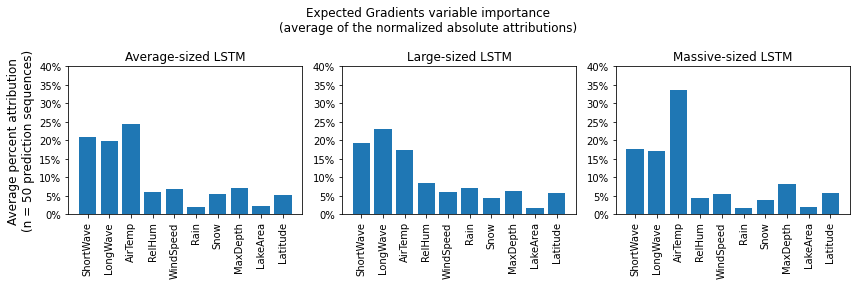

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

fig.suptitle('Expected Gradients variable importance\n(average of the normalized absolute attributions)')

# Take the absolute value of EGs and aggregrate them across lakes and days
avg_rel_abs_attribution_by_var = get_relative_abs_attribution_by_var(avg_valid_eg_results)
large_rel_abs_attribution_by_var = get_relative_abs_attribution_by_var(large_valid_eg_results)
massive_rel_abs_attribution_by_var = get_relative_abs_attribution_by_var(massive_valid_eg_results)

# Determine a shared y-maximum for plotting
ymax = np.max([np.max(avg_rel_abs_attribution_by_var),
               np.max(large_rel_abs_attribution_by_var),
               np.max(massive_rel_abs_attribution_by_var)])
ymax = ymax + ymax*0.05

# Plot both
ax[0].bar(range(len(valid_variables)),
          avg_rel_abs_attribution_by_var)
ax[0].set_ylabel('Average percent attribution\n(n = ' +
                 str(n_eg) + ' prediction sequences)',
                 fontsize = 12)
ax[0].set_title('Average-sized LSTM')

ax[1].bar(range(len(valid_variables)),
          large_rel_abs_attribution_by_var)
ax[1].set_title('Large-sized LSTM')

ax[2].bar(range(len(valid_variables)),
          massive_rel_abs_attribution_by_var)
ax[2].set_title('Massive-sized LSTM')

for i in range(3):
    ax[i].set_xticks(range(len(valid_variables)),
                     valid_variables,
                     rotation = 90)
    ax[i].set_ylim(0, ymax)
    ax[i].set_yticks(ax[i].get_yticks(), [str(int(100*tick))+'%' for tick in ax[i].get_yticks()])
    
plt.tight_layout()
    
print('\nAvg model increasing importance:\t', valid_variables[np.argsort(avg_rel_abs_attribution_by_var)], '\n\n',
      '\nLarge model increasing importance:\t', valid_variables[np.argsort(large_rel_abs_attribution_by_var)], '\n\n',
      '\nMassive model increasing importance:\t', valid_variables[np.argsort(massive_rel_abs_attribution_by_var)])

In [12]:
avg_rel_abs_attribution_by_var, large_rel_abs_attribution_by_var, massive_rel_abs_attribution_by_var

(array([0.20986056, 0.19679928, 0.24287166, 0.06062417, 0.06737716,
        0.02084552, 0.05518933, 0.07255555, 0.02203955, 0.05183722]),
 array([0.19385078, 0.22927562, 0.17299425, 0.08572601, 0.06032691,
        0.07230859, 0.04549724, 0.06402406, 0.01831116, 0.05768537]),
 array([0.17784903, 0.17232841, 0.33662371, 0.04406879, 0.05412481,
        0.01757858, 0.03949211, 0.08104363, 0.01995506, 0.05693586]))

In [13]:
print(np.sum(avg_rel_abs_attribution_by_var[-3:]),
      np.sum(large_rel_abs_attribution_by_var[-3:]),
      np.sum(massive_rel_abs_attribution_by_var[-3:]))

0.1464323151463123 0.14002059422440788 0.157934553138408


#### When using latitude, not using process-based inputs, and comparing models of different sizes

The relative importance of variables is pretty similar. Both models favor the following top-3 variables:
* air temperature
* shortwave radiation
* longwave radiation

The remaining dynamic variables have largely comparable attribution, with the exception of rain which is largely discounted by the average and massive models.

Static variables are generally not assigned large attribution, but depth and latitude are notably higher than lake area.

<br><br><br><br><br>

# Plot EGs for individual sequences

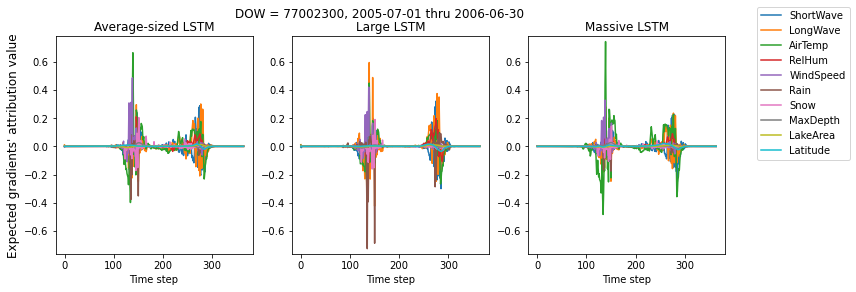

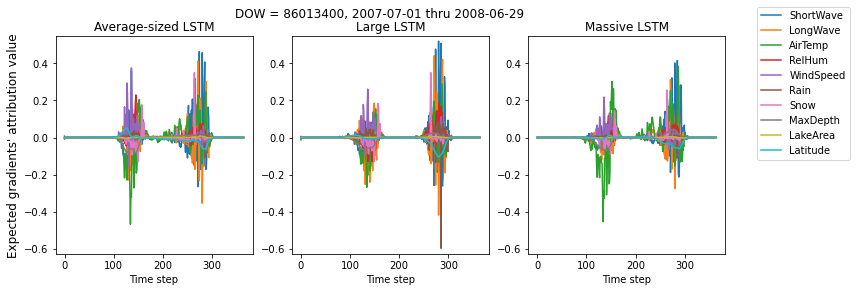

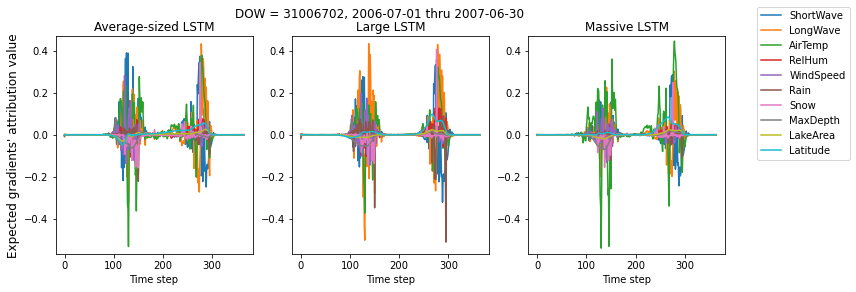

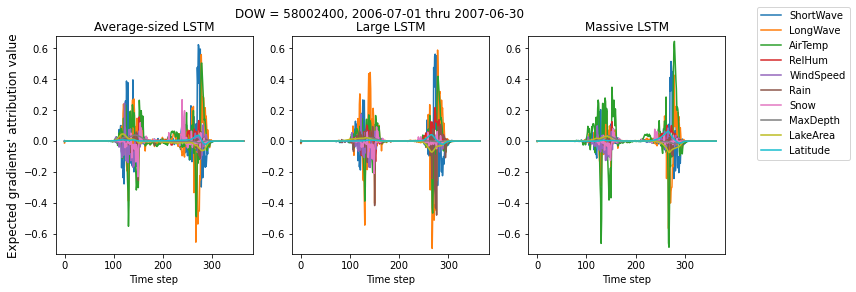

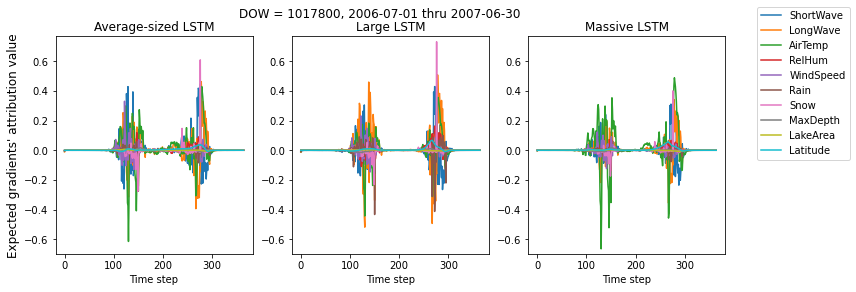

In [14]:
for i in range(5):
    fig, ax = plt.subplots(1, 3, figsize = (12, 4))
    
    # draw a random index
    rand_i = np.random.choice(n_eg)
    
    # format some information with that random index
    rand_dow = str(valid_DOW[avg_valid_eg_IDs[rand_i]])
    rand_start_date = valid_dates[avg_valid_eg_IDs[rand_i]][0]
    rand_end_date = valid_dates[avg_valid_eg_IDs[rand_i]][-1]
    
    # get info to make axes the same
    avg_cur_egs = avg_valid_eg_results[rand_i, :, :]
    large_cur_egs = large_valid_eg_results[rand_i, :, :]
    massive_cur_egs = massive_valid_eg_results[rand_i, :, :] 
    ymin = np.min([np.min(avg_cur_egs), np.min(large_cur_egs), np.min(massive_cur_egs)])
    ymax = np.max([np.max(avg_cur_egs), np.max(large_cur_egs), np.max(massive_cur_egs)])
    ymin = ymin + ymin*0.05
    ymax = ymax + ymax*0.05
    
    # plot
    for var_i in range(len(valid_variables)):
        ax[0].plot(avg_valid_eg_results[rand_i, :, var_i])
        ax[1].plot(large_valid_eg_results[rand_i, :, var_i])
        ax[2].plot(massive_valid_eg_results[rand_i, :, var_i], label = valid_variables[var_i])
    for j in range(3):
        ax[j].set_ylim(ymin, ymax)
        ax[j].set_xlabel('Time step')
    ax[0].set_ylabel("Expected gradients' attribution value",
                     fontsize = 12)
    ax[0].set_title('Average-sized LSTM')
    ax[1].set_title('Large LSTM')
    ax[2].set_title('Massive LSTM')
    fig.legend(bbox_to_anchor = (1.05, 1))
    fig.suptitle('DOW = ' + rand_dow + ", " + rand_start_date + ' thru ' + rand_end_date)

#### When not using latitude, not using process-based inputs, and comparing models of different sizes

Attributes are much smaller magnitude but still active outside transition periods for the average and massive model. That is, attributions do occur during the dead of winter (but not the heat of summer).

Exact variable and magnitude of activation can vary noticeably.

<br><br><br><br><br>

# EGs targetted at predicted ice on transition

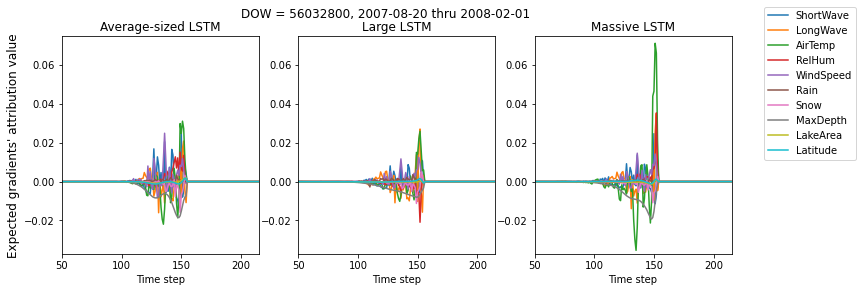

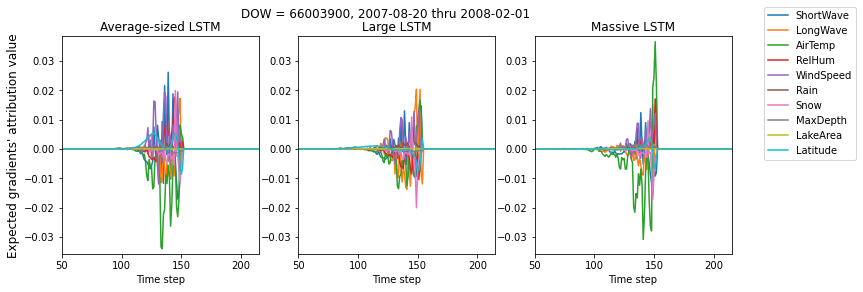

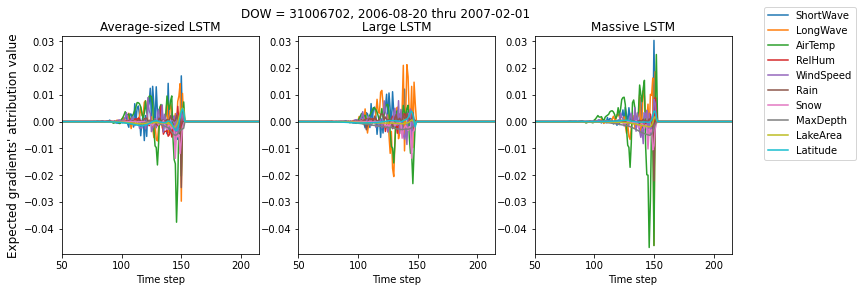

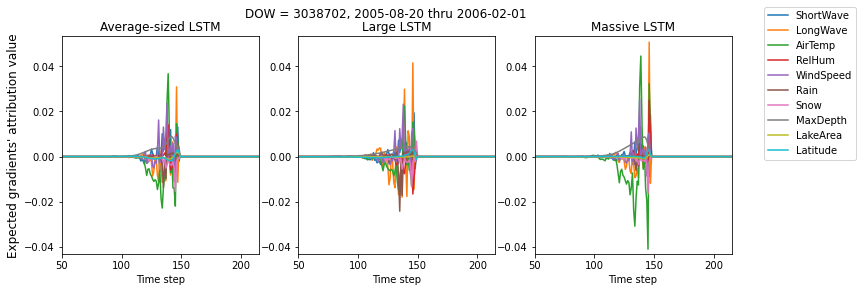

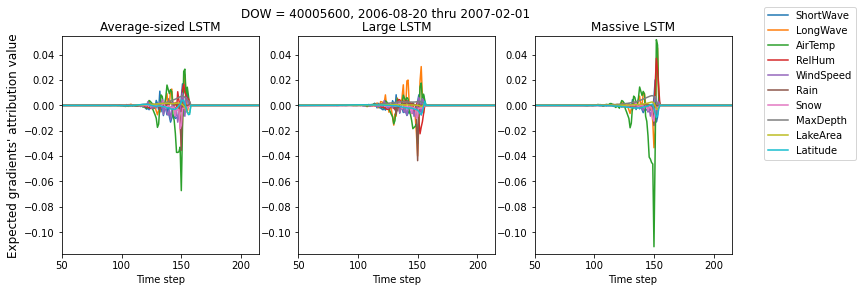

In [15]:
for i in range(5):
    fig, ax = plt.subplots(1, 3, figsize = (12, 4))
    
    # draw a random index
    rand_i = np.random.choice(n_eg_fine)
    
    # format some information with that random index
    rand_dow = str(valid_DOW[avg_valid_eg_IDs_ice_on[rand_i]])
    rand_start_date = valid_dates[avg_valid_eg_IDs_ice_on[rand_i]][ice_on_start]
    rand_end_date = valid_dates[avg_valid_eg_IDs_ice_on[rand_i]][ice_on_end]
    
    # get info to make axes the same
    avg_cur_egs = avg_valid_eg_results_ice_on[rand_i, :, :]
    large_cur_egs = large_valid_eg_results_ice_on[rand_i, :, :]
    massive_cur_egs = massive_valid_eg_results_ice_on[rand_i, :, :] 
    ymin = np.min([np.min(avg_cur_egs), np.min(large_cur_egs), np.min(massive_cur_egs)])
    ymax = np.max([np.max(avg_cur_egs), np.max(large_cur_egs), np.max(massive_cur_egs)])
    ymin = ymin + ymin*0.05
    ymax = ymax + ymax*0.05
    
    for j in range(len(valid_variables)):
        ax[0].plot(avg_valid_eg_results_ice_on[rand_i, :, j])
        ax[1].plot(large_valid_eg_results_ice_on[rand_i, :, j])
        ax[2].plot(massive_valid_eg_results_ice_on[rand_i, :, j], label = valid_variables[j])
    for k in range(3):
        ax[k].set_ylim(ymin, ymax)
        ax[k].set_xlim(ice_on_start, ice_on_end)
        ax[k].set_xlabel('Time step')
    ax[0].set_ylabel("Expected gradients' attribution value",
                     fontsize = 12)
    ax[0].set_title('Average-sized LSTM')
    ax[1].set_title('Large LSTM')
    ax[2].set_title('Massive LSTM')
    fig.suptitle('DOW = ' + rand_dow + ", " + rand_start_date + ' thru ' + rand_end_date)
    fig.legend(bbox_to_anchor = (1.05, 1))

# EGs targetted at predicted ice off transition

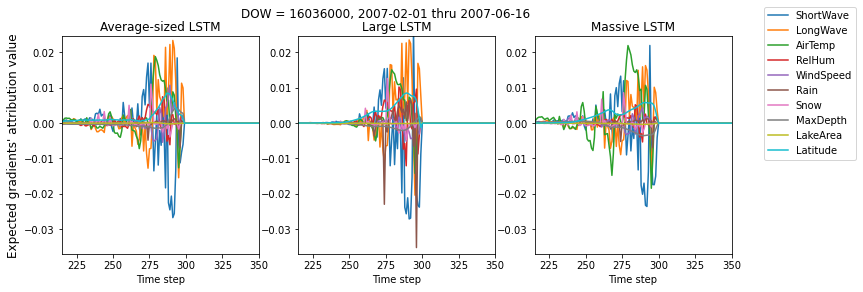

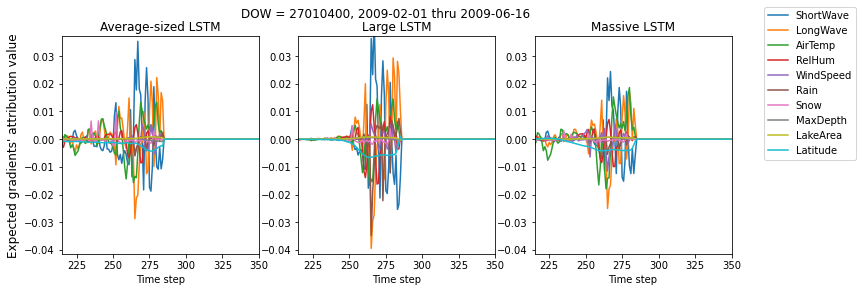

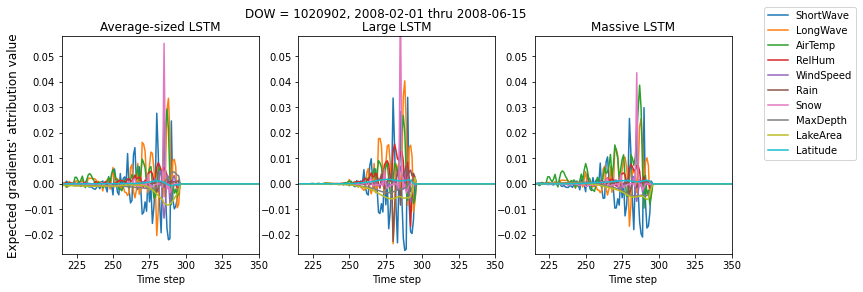

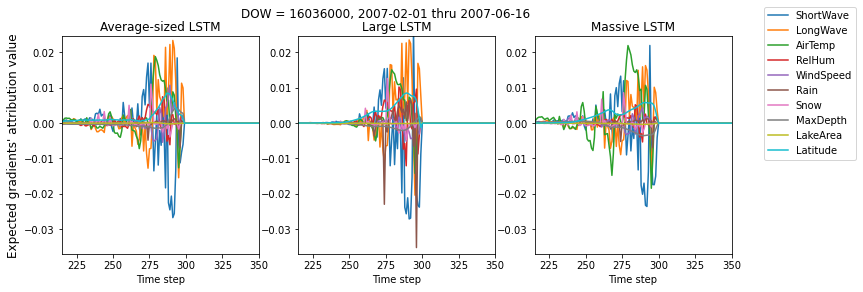

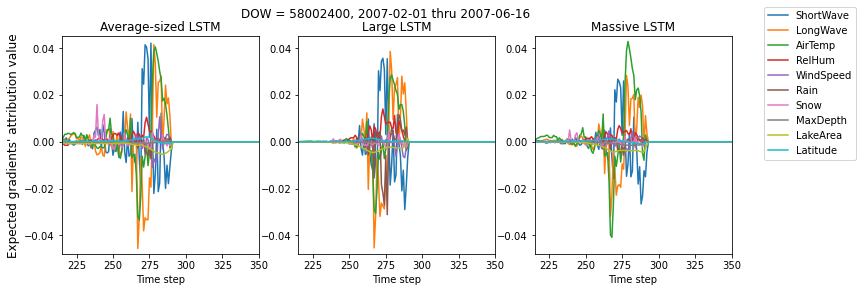

In [16]:
for i in range(5):
    fig, ax = plt.subplots(1, 3, figsize = (12, 4))
    
    # draw a random index
    rand_i = np.random.choice(n_eg_fine)
    
    # format some information with that random index
    rand_dow = str(valid_DOW[avg_valid_eg_IDs_ice_off[rand_i]])
    rand_start_date = valid_dates[avg_valid_eg_IDs_ice_off[rand_i]][ice_off_start]
    rand_end_date = valid_dates[avg_valid_eg_IDs_ice_off[rand_i]][ice_off_end]
    
    # get info to make axes the same
    avg_cur_egs = avg_valid_eg_results_ice_off[rand_i, :, :]
    large_cur_egs = large_valid_eg_results_ice_off[rand_i, :, :]
    massive_cur_egs = massive_valid_eg_results_ice_off[rand_i, :, :] 
    ymin = np.min([np.min(avg_cur_egs), np.min(large_cur_egs), np.min(massive_cur_egs)])
    ymax = np.max([np.max(avg_cur_egs), np.min(large_cur_egs), np.max(massive_cur_egs)])
    ymin = ymin + ymin*0.05
    ymax = ymax + ymax*0.05
    
    for j in range(len(valid_variables)):
        ax[0].plot(avg_valid_eg_results_ice_off[rand_i, :, j])
        ax[1].plot(large_valid_eg_results_ice_off[rand_i, :, j])
        ax[2].plot(massive_valid_eg_results_ice_off[rand_i, :, j], label = valid_variables[j])
    for k in range(3):
        ax[k].set_ylim(ymin, ymax)
        ax[k].set_xlim(ice_off_start, ice_off_end)
        ax[k].set_xlabel('Time step')
    ax[0].set_ylabel("Expected gradients' attribution value",
                     fontsize = 12)
    ax[0].set_title('Average-sized LSTM')
    ax[1].set_title('Large LSTM')
    ax[2].set_title('Massive LSTM')
    fig.suptitle('DOW = ' + rand_dow + ", " + rand_start_date + ' thru ' + rand_end_date)
    fig.legend(bbox_to_anchor = (1.05, 1))

#### When using latitude, not using process-based inputs, and comparing models of different size

Compared to ice on prediction, ice off prediction appears to utilize data a lot more (i.e., magnitude and duration of attributions)

These plots generally look a lot more similar than the ice on plots. 

<br><br><br><br><br>

# Compare how EGs vary when predicting ice-on versus ice-off transition

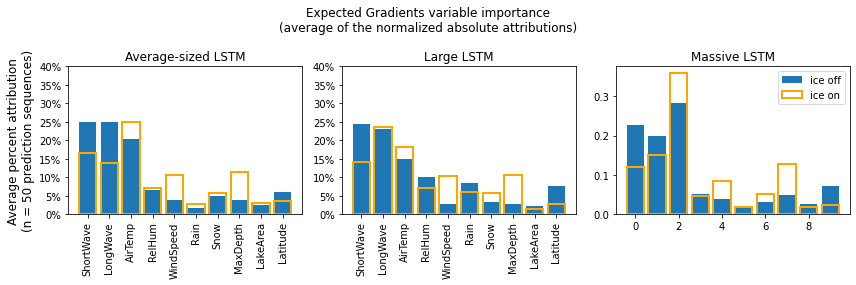

In [17]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

fig.suptitle('Expected Gradients variable importance\n(average of the normalized absolute attributions)')

# Take the absolute value of EGs and aggregrate them across lakes and days
avg_rel_abs_attribution_by_var_ice_on = get_relative_abs_attribution_by_var(avg_valid_eg_results_ice_on)
avg_rel_abs_attribution_by_var_ice_off = get_relative_abs_attribution_by_var(avg_valid_eg_results_ice_off)
large_rel_abs_attribution_by_var_ice_on = get_relative_abs_attribution_by_var(large_valid_eg_results_ice_on)
large_rel_abs_attribution_by_var_ice_off = get_relative_abs_attribution_by_var(large_valid_eg_results_ice_off)
massive_rel_abs_attribution_by_var_ice_on = get_relative_abs_attribution_by_var(massive_valid_eg_results_ice_on)
massive_rel_abs_attribution_by_var_ice_off = get_relative_abs_attribution_by_var(massive_valid_eg_results_ice_off)

# Determine a shared y-maximum for plotting
ymax = np.max([np.max(avg_rel_abs_attribution_by_var_ice_on),
               np.max(avg_rel_abs_attribution_by_var_ice_off),
               np.max(large_rel_abs_attribution_by_var_ice_on),
               np.max(large_rel_abs_attribution_by_var_ice_off),
               np.max(massive_rel_abs_attribution_by_var_ice_on),
               np.max(massive_rel_abs_attribution_by_var_ice_off)])
ymax = ymax + ymax*0.05

# Plot both ice on and ice off
ax[0].bar(range(len(valid_variables)),
          avg_rel_abs_attribution_by_var_ice_off,
          label = 'ice off')
ax[0].bar(range(len(valid_variables)),
          avg_rel_abs_attribution_by_var_ice_on,
          color = 'none',
          edgecolor = 'orange',
          linewidth = 2,
          label = 'ice on')
ax[0].set_ylabel('Average percent attribution\n(n = ' +
                 str(n_eg_fine) + ' prediction sequences)',
                 fontsize = 12)

ax[1].bar(range(len(valid_variables)),
          large_rel_abs_attribution_by_var_ice_off,
          label = 'ice off')
ax[1].bar(range(len(valid_variables)),
          large_rel_abs_attribution_by_var_ice_on,
          color = 'none',
          edgecolor = 'orange',
          linewidth = 2,
          label = 'ice on')

ax[2].bar(range(len(valid_variables)),
          massive_rel_abs_attribution_by_var_ice_off,
          label = 'ice off')
ax[2].bar(range(len(valid_variables)),
          massive_rel_abs_attribution_by_var_ice_on,
          color = 'none',
          edgecolor = 'orange',
          linewidth = 2,
          label = 'ice on')

# Format plot
ax[0].set_title('Average-sized LSTM')
ax[1].set_title('Large LSTM')
ax[2].set_title('Massive LSTM')
plt.legend()

for i in range(2):
    ax[i].set_xticks(range(len(valid_variables)),
                     valid_variables,
                     rotation = 90)
    ax[i].set_ylim(0, ymax)
    ax[i].set_yticks(ax[i].get_yticks(), [str(int(100*tick))+'%' for tick in ax[i].get_yticks()])
plt.tight_layout()

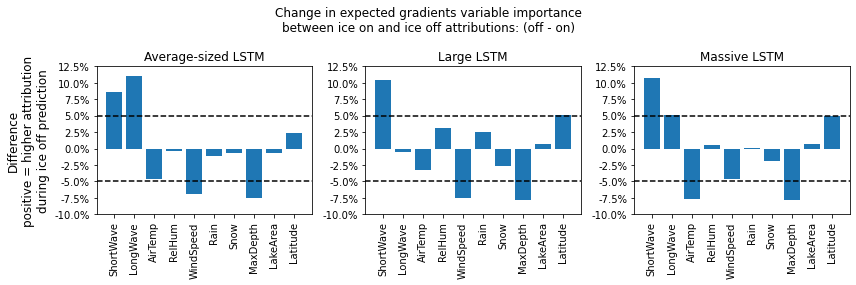

In [18]:
avg_ice_off_percent_change_relative_ice_on = ((avg_rel_abs_attribution_by_var_ice_off -
                                               avg_rel_abs_attribution_by_var_ice_on))

large_ice_off_percent_change_relative_ice_on = ((large_rel_abs_attribution_by_var_ice_off -
                                                 large_rel_abs_attribution_by_var_ice_on))

massive_ice_off_percent_change_relative_ice_on = ((massive_rel_abs_attribution_by_var_ice_off -
                                                   massive_rel_abs_attribution_by_var_ice_on))

ymin = np.min([np.min(avg_ice_off_percent_change_relative_ice_on),
               np.min(large_ice_off_percent_change_relative_ice_on),
               np.min(massive_ice_off_percent_change_relative_ice_on)])
ymax = np.max([np.max(avg_ice_off_percent_change_relative_ice_on),
               np.max(large_ice_off_percent_change_relative_ice_on),
               np.max(massive_ice_off_percent_change_relative_ice_on)])
ymin = ymin + ymin*0.05
ymax = ymax + ymax*0.05


fig, ax = plt.subplots(1, 3, figsize = (12, 4))

fig.suptitle('Change in expected gradients variable importance\n' +
             'between ice on and ice off attributions: (off - on)')

ax[0].bar(range(len(valid_variables)),
          avg_ice_off_percent_change_relative_ice_on,
          label = 'ice off')
ax[1].bar(range(len(valid_variables)),
          large_ice_off_percent_change_relative_ice_on,
          label = 'ice off')
ax[2].bar(range(len(valid_variables)),
          massive_ice_off_percent_change_relative_ice_on,
          label = 'ice off')

ax[0].set_ylabel('Difference\n' +
                 'positive = higher attribution\n' + 
                 'during ice off prediction',
                 fontsize = 12)

for i in range(3):
    ax[i].set_ylim(ymin, ymax)
    ax[i].set_xticks(range(len(valid_variables)),
                     valid_variables,
                     rotation = 90)
    ax[i].set_yticks(ax[i].get_yticks(), [str(np.round(100*tick, 1))+'%' for tick in ax[i].get_yticks()])
    ax[i].axhline(0.05, color = 'black', linestyle = '--')
    ax[i].axhline(-0.05, color = 'black', linestyle = '--')
    
ax[0].set_title('Average-sized LSTM')
ax[1].set_title('Large LSTM')
ax[2].set_title('Massive LSTM')
plt.tight_layout();

In [19]:
avg_ice_off_percent_change_relative_ice_on

array([ 0.08605862,  0.10959466, -0.04546846, -0.00361751, -0.06898079,
       -0.01138889, -0.00698708, -0.07555156, -0.00673816,  0.02307918])

In [20]:
large_ice_off_percent_change_relative_ice_on

array([ 0.10376944, -0.0049955 , -0.03275011,  0.03067589, -0.0749956 ,
        0.02515167, -0.0258793 , -0.07861734,  0.00740745,  0.0502334 ])

In [21]:
massive_ice_off_percent_change_relative_ice_on

array([ 0.10645146,  0.05039239, -0.07592922,  0.00545974, -0.04662547,
        0.00099245, -0.01929299, -0.07779982,  0.00650639,  0.04984507])

In [22]:
np.mean([0.04984507, 0.02307918, 0.0502334  ])

0.04105255

#### When using latitude,  not using process-based inputs, and comparing models of different sizes


All models have increased attribution to the following variables when predicting ice off:

* Short wave radiation*
* Latitude

Both models have increased attribution to the following variables when predicting ice on:

* Max depth*
* Air temperature
* Wind speed*
* Snow

<br><br><br><br><br>

# How EGs vary by static var

### Add in lat & long

In [23]:
# Read in the MN lake metadata, focusing on coordiantes and lake size
lat_lon_ref_df = pd.read_excel(mapping_reference,
                               usecols=['dow num', 'lat', 'long', 'acres'])
lat_lon_ref_df = lat_lon_ref_df.rename(columns = {'dow num':'DOW'})

# Merge that information with the validation set DOWs
seq_DOWs = pd.DataFrame({'DOW':valid_DOW})
mapping_df = seq_DOWs.merge(lat_lon_ref_df, on='DOW', how = 'left')

### Extract static variables

SpearmanrResult(correlation=0.6074800170780539, pvalue=2.8967217386850654e-06)

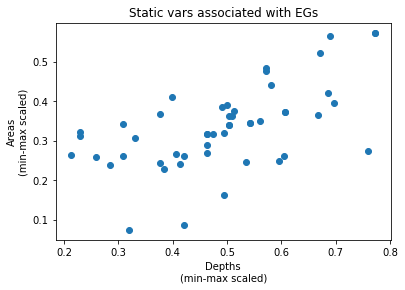

In [24]:
# ID tensor location
depth_i = np.argwhere(valid_variables == 'MaxDepth').item()
area_i = np.argwhere(valid_variables == 'LakeArea').item()
# convert to numpy
#valid_x = valid_x.numpy()
# Extract depths and areas for the subset of data that we have EGs for
depths = valid_x[avg_valid_eg_IDs_ice_on, 0, depth_i]
areas = valid_x[avg_valid_eg_IDs_ice_on, 0, area_i]

# See if/how much they're correlated with each other
plt.scatter(x = depths, y = areas)
plt.xlabel('Depths\n(min-max scaled)')
plt.ylabel('Areas\n(min-max scaled)')
plt.title('Static vars associated with EGs')
spearmanr(depths, areas)

SpearmanrResult(correlation=0.20897889080976945, pvalue=0.14526415275364443) 
 SpearmanrResult(correlation=0.21902017291066284, pvalue=0.12647374265745964) 
 SpearmanrResult(correlation=0.0022098917189079066, pvalue=0.9878478358434155) 
 SpearmanrResult(correlation=0.03093179634966379, pvalue=0.8311399982349276)


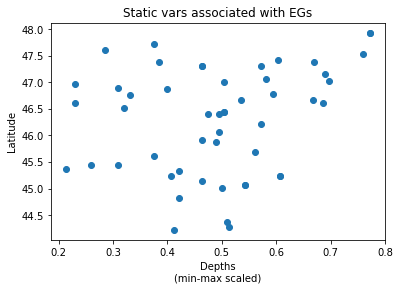

In [25]:
# See if/how much they're correlated with each other
lats = mapping_df['lat'][avg_valid_eg_IDs_ice_on]
longs = mapping_df['long'][avg_valid_eg_IDs_ice_on]
plt.scatter(x = depths, y = lats)
plt.xlabel('Depths\n(min-max scaled)')
plt.ylabel('Latitude')
plt.title('Static vars associated with EGs')
print(spearmanr(depths, lats), '\n',
      spearmanr(areas, lats), '\n',
      spearmanr(depths, longs), '\n',
      spearmanr(areas, longs))

Area and depth are significantly and positively correlated in this sample.

Latitude and longitude are independent of the others

In [26]:
# For both model sizes and ice on/off...
avg_num_attributed_days_ice_on_ls = []
large_num_attributed_days_ice_on_ls = []
massive_num_attributed_days_ice_on_ls = []
avg_num_attributed_days_ice_off_ls = []
large_num_attributed_days_ice_off_ls = []
massive_num_attributed_days_ice_off_ls = []

# Figure out how many days account for 95% of EG attributions
for i in range(n_eg_fine):
    avg_num_attributed_days_ice_on_ls.append(calc_num_attributed_days(avg_valid_eg_results_ice_on[i, :, :]))
    large_num_attributed_days_ice_on_ls.append(calc_num_attributed_days(large_valid_eg_results_ice_on[i, :, :]))
    massive_num_attributed_days_ice_on_ls.append(calc_num_attributed_days(massive_valid_eg_results_ice_on[i, :, :]))
    avg_num_attributed_days_ice_off_ls.append(calc_num_attributed_days(avg_valid_eg_results_ice_off[i, :, :]))
    large_num_attributed_days_ice_off_ls.append(calc_num_attributed_days(large_valid_eg_results_ice_off[i, :, :]))
    massive_num_attributed_days_ice_off_ls.append(calc_num_attributed_days(massive_valid_eg_results_ice_off[i, :, :]))

## Ice on

### Plot static variable values versus an approximation of how long the model remembers

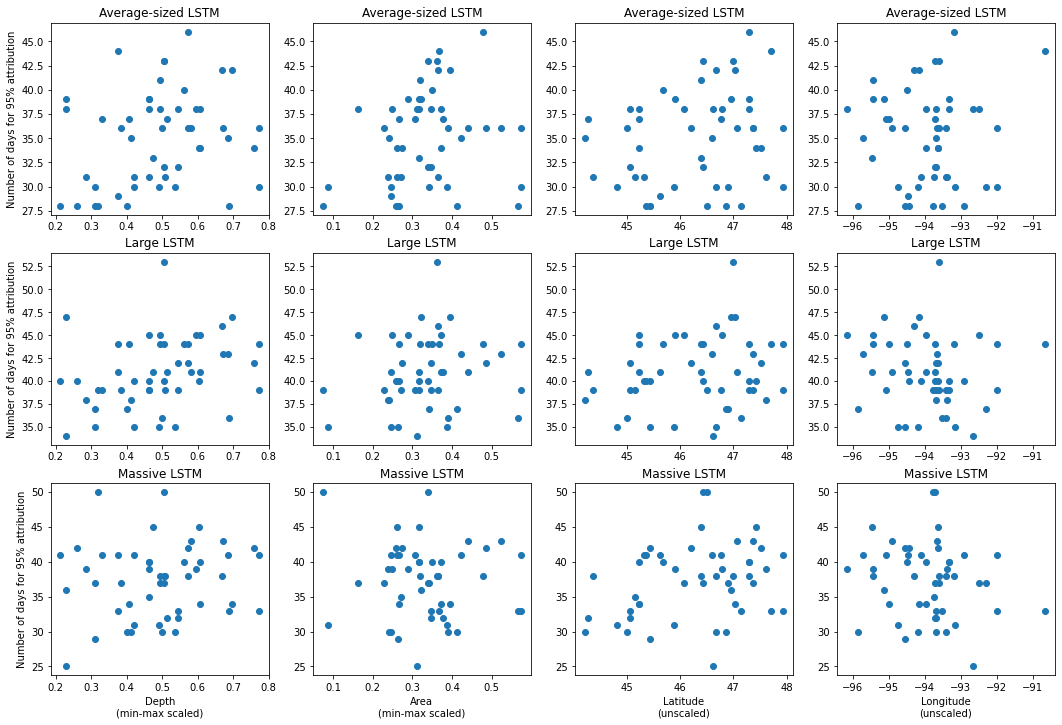

In [27]:
fig, ax = plt.subplots(3, 4, figsize = (18, 12))

# plot static variable values vs how many days account for 95% of EG attributions
ax[0, 0].scatter(depths, avg_num_attributed_days_ice_on_ls)
ax[0, 1].scatter(areas, avg_num_attributed_days_ice_on_ls)
ax[0, 2].scatter(lats, avg_num_attributed_days_ice_on_ls)
ax[0, 3].scatter(longs, avg_num_attributed_days_ice_on_ls)
ax[1, 0].scatter(depths, large_num_attributed_days_ice_on_ls)
ax[1, 1].scatter(areas, large_num_attributed_days_ice_on_ls)
ax[1, 2].scatter(lats, large_num_attributed_days_ice_on_ls)
ax[1, 3].scatter(longs, large_num_attributed_days_ice_on_ls)
ax[2, 0].scatter(depths, massive_num_attributed_days_ice_on_ls)
ax[2, 1].scatter(areas, massive_num_attributed_days_ice_on_ls)
ax[2, 2].scatter(lats, massive_num_attributed_days_ice_on_ls)
ax[2, 3].scatter(longs, massive_num_attributed_days_ice_on_ls)

ax[0, 0].set_ylabel('Number of days for 95% attribution')
ax[1, 0].set_ylabel('Number of days for 95% attribution')
ax[2, 0].set_ylabel('Number of days for 95% attribution')
ax[2, 0].set_xlabel('Depth\n(min-max scaled)')
ax[2, 1].set_xlabel('Area\n(min-max scaled)')
ax[2, 2].set_xlabel('Latitude\n(unscaled)')
ax[2, 3].set_xlabel('Longitude\n(unscaled)')
for i in range(4):
    ax[0, i].set_title('Average-sized LSTM')
    ax[1, i].set_title('Large LSTM')
    ax[2, i].set_title('Massive LSTM');

In [28]:
# Get associated correlations and p-values
for model in [avg_num_attributed_days_ice_on_ls, large_num_attributed_days_ice_on_ls, massive_num_attributed_days_ice_on_ls]:
    print(spearmanr(depths, model))
    print(spearmanr(areas, model))
    print(spearmanr(lats, model))
    print(spearmanr(longs, model))
    print('\n')

SpearmanrResult(correlation=0.23189230944915426, pvalue=0.10514068404823453)
SpearmanrResult(correlation=0.2284440805299249, pvalue=0.11056316670510392)
SpearmanrResult(correlation=0.1941256534094889, pvalue=0.17674422571865728)
SpearmanrResult(correlation=-0.00016870013331675014, pvalue=0.999072285756912)


SpearmanrResult(correlation=0.3645125588609431, pvalue=0.00925423914463125)
SpearmanrResult(correlation=0.21351786813608586, pvalue=0.1365290958407562)
SpearmanrResult(correlation=0.1488154838524235, pvalue=0.30234097583683467)
SpearmanrResult(correlation=-0.23012803245965294, pvalue=0.10788896522925555)


SpearmanrResult(correlation=0.13946190463226246, pvalue=0.33407749407744514)
SpearmanrResult(correlation=-0.06411790232815703, pvalue=0.6582212049334426)
SpearmanrResult(correlation=0.27590200630054507, pvalue=0.052452111160984215)
SpearmanrResult(correlation=-0.1556117171411487, pvalue=0.2805430052758457)




#### When using latitude, not using process-based inputs, and comparing models of different sizes

In this small sample and univariate inspection, the models largely do not appear to have correlated static variables with the amount of time steps they effectively remember.

One exception is that the large LSTM memory is positively and significantly correlated with lake depth.

<br><br><br><br><br>

## Ice off

### Plot static variable values versus an approximation of how long the model remembers

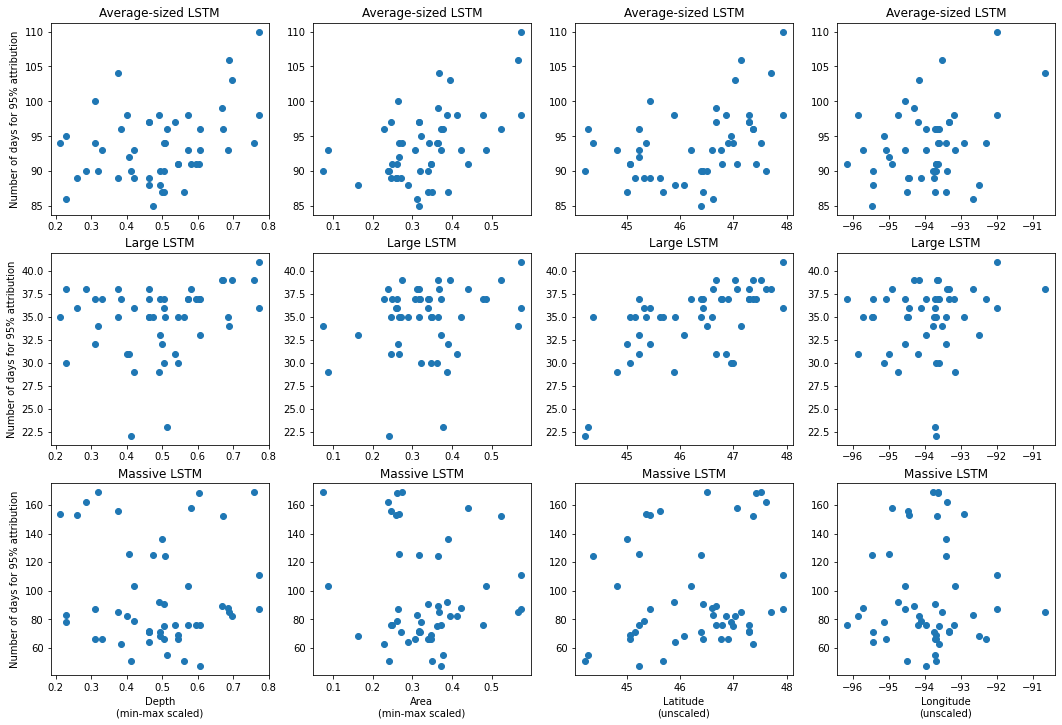

In [29]:
fig, ax = plt.subplots(3, 4, figsize = (18, 12))

# plot static variable values vs how many days account for 95% of EG attributions
ax[0, 0].scatter(depths, avg_num_attributed_days_ice_off_ls)
ax[0, 1].scatter(areas, avg_num_attributed_days_ice_off_ls)
ax[0, 2].scatter(lats, avg_num_attributed_days_ice_off_ls)
ax[0, 3].scatter(longs, avg_num_attributed_days_ice_off_ls)
ax[1, 0].scatter(depths, large_num_attributed_days_ice_off_ls)
ax[1, 1].scatter(areas, large_num_attributed_days_ice_off_ls)
ax[1, 2].scatter(lats, large_num_attributed_days_ice_off_ls)
ax[1, 3].scatter(longs, large_num_attributed_days_ice_off_ls)
ax[2, 0].scatter(depths, massive_num_attributed_days_ice_off_ls)
ax[2, 1].scatter(areas, massive_num_attributed_days_ice_off_ls)
ax[2, 2].scatter(lats, massive_num_attributed_days_ice_off_ls)
ax[2, 3].scatter(longs, massive_num_attributed_days_ice_off_ls)

ax[0, 0].set_ylabel('Number of days for 95% attribution')
ax[1, 0].set_ylabel('Number of days for 95% attribution')
ax[2, 0].set_ylabel('Number of days for 95% attribution')
ax[2, 0].set_xlabel('Depth\n(min-max scaled)')
ax[2, 1].set_xlabel('Area\n(min-max scaled)')
ax[2, 2].set_xlabel('Latitude\n(unscaled)')
ax[2, 3].set_xlabel('Longitude\n(unscaled)')
for i in range(4):
    ax[0, i].set_title('Average-sized LSTM')
    ax[1, i].set_title('Large LSTM')
    ax[2, i].set_title('Massive LSTM');

In [30]:
for model in [avg_num_attributed_days_ice_off_ls, large_num_attributed_days_ice_off_ls, massive_num_attributed_days_ice_off_ls]:
    print(spearmanr(depths, model))
    print(spearmanr(areas, model))
    print(spearmanr(lats, model))
    print(spearmanr(longs, model))
    print('\n')

SpearmanrResult(correlation=0.2902193928873235, pvalue=0.040905137484402554)
SpearmanrResult(correlation=0.46279613780774637, pvalue=0.0007142187308646982)
SpearmanrResult(correlation=0.440737585292818, pvalue=0.001358262594388648)
SpearmanrResult(correlation=0.2077742260903963, pvalue=0.1476505784276918)


SpearmanrResult(correlation=0.25294438352748433, pvalue=0.07634579449049161)
SpearmanrResult(correlation=0.18460075882635124, pvalue=0.19936187985789294)
SpearmanrResult(correlation=0.6279334807457618, pvalue=1.0539940214157727e-06)
SpearmanrResult(correlation=0.20777585080770278, pvalue=0.14764734046493)


SpearmanrResult(correlation=0.007907513924128834, pvalue=0.9565358991848937)
SpearmanrResult(correlation=-0.012255198655006924, pvalue=0.9326838319986009)
SpearmanrResult(correlation=0.21348075460996377, pvalue=0.13659889012626125)
SpearmanrResult(correlation=0.03157515888760608, pvalue=0.8276806623532629)




#### When using latitude, not using process-based inputs, and comparing models of different sizes

Here it appears that smaller models have more significant correlations between LSTM memory and static variables. The average LSTM positively and significantly correlates LSTM memory with depth, area, and latitude; the large LSTM positively and significantly correlates LSTM memory with latitude; and the massive LSTM's memory displays no significant correlations.

<br><br><br><br><br>

# Compare memory for both models between ice on and ice off

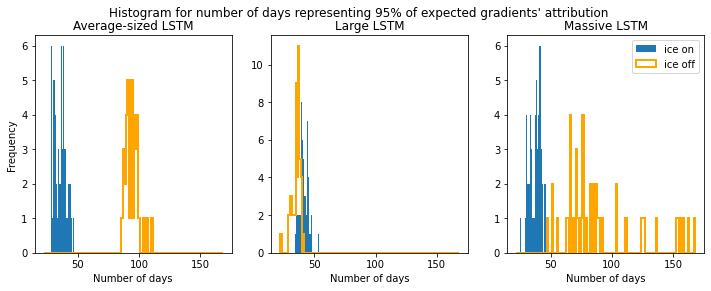

In [31]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

fig.suptitle("Histogram for number of days representing 95% of expected gradients' attribution")

ymin = min(min(avg_num_attributed_days_ice_on_ls), min(large_num_attributed_days_ice_off_ls), min(massive_num_attributed_days_ice_off_ls))
ymax = max(max(avg_num_attributed_days_ice_on_ls), max(large_num_attributed_days_ice_off_ls), max(massive_num_attributed_days_ice_off_ls))

ax[0].hist(avg_num_attributed_days_ice_on_ls, bins = range(ymin, ymax))
ax[0].hist(avg_num_attributed_days_ice_off_ls, bins = range(ymin, ymax),
           linewidth = 2, histtype = 'step', color = 'orange')

ax[1].hist(large_num_attributed_days_ice_on_ls, bins = range(ymin, ymax))
ax[1].hist(large_num_attributed_days_ice_off_ls, bins = range(ymin, ymax),
           linewidth = 2, histtype = 'step', color = 'orange')

ax[2].hist(massive_num_attributed_days_ice_on_ls, bins = range(ymin, ymax),
           label = 'ice on')
ax[2].hist(massive_num_attributed_days_ice_off_ls, bins = range(ymin, ymax),
           linewidth = 2, histtype = 'step', color = 'orange',
           label = 'ice off')
plt.legend()

ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Number of days')
ax[1].set_xlabel('Number of days')
ax[2].set_xlabel('Number of days')

ax[0].set_title('Average-sized LSTM')
ax[1].set_title('Large LSTM')
ax[2].set_title('Massive LSTM');

In [32]:
np.mean(avg_num_attributed_days_ice_on_ls), np.mean(avg_num_attributed_days_ice_off_ls)

(35.06, 93.6)

In [33]:
np.mean(large_num_attributed_days_ice_on_ls), np.mean(large_num_attributed_days_ice_off_ls)

(40.92, 34.74)

In [34]:
np.mean(massive_num_attributed_days_ice_on_ls), np.mean(massive_num_attributed_days_ice_off_ls)

(37.36, 95.46)

In [35]:
np.std(avg_num_attributed_days_ice_off_ls), np.std(massive_num_attributed_days_ice_off_ls)

(5.176871642217914, 35.61079049951012)

#### When using latitude, not using process-based inputs, and comparing models of different sizes

Across models, ice on memory is greater than 1 month. Ice off memory is much more variable with two models appearing to remember the entire icy season while another, similar to ice on emmory, remembers just over 1 month.

<br><br><br><br><br>

# View Permutation

In [36]:
# original validation losses for scaling
avg_valid_loss = avg_valid_loss_list[avg_valid_loss_list != 0].min()
large_valid_loss = large_valid_loss_list[large_valid_loss_list != 0].min()
massive_valid_loss = massive_valid_loss_list[massive_valid_loss_list != 0].min()

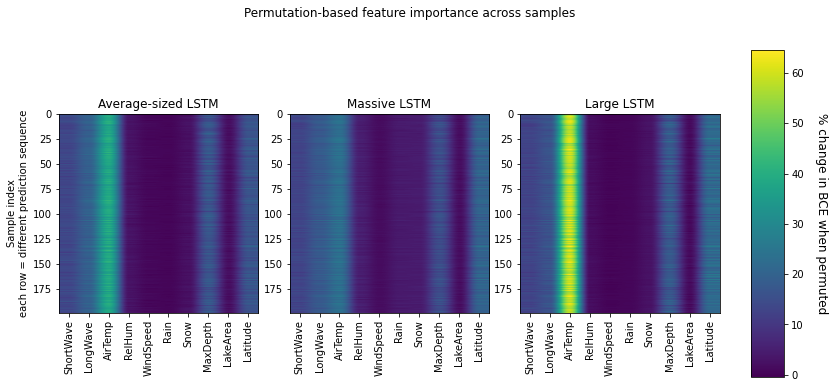

In [37]:
fig, ax = plt.subplots(1, 4, figsize = (13, 6), gridspec_kw={'width_ratios': [6, 6, 6, 1]})

fig.suptitle("Permutation-based feature importance across samples")

avg_change_relative_to_base = 100*(avg_permutation_results - avg_valid_loss) / avg_valid_loss
large_change_relative_to_base = 100*(large_permutation_results - large_valid_loss) / large_valid_loss
massive_change_relative_to_base = 100*(massive_permutation_results - massive_valid_loss) / massive_valid_loss

vmin = np.min([np.min(avg_change_relative_to_base),
               np.min(large_change_relative_to_base),
               np.min(massive_change_relative_to_base)])
vmax = np.max([np.max(avg_change_relative_to_base),
               np.min(large_change_relative_to_base),
               np.max(massive_change_relative_to_base)])

im = ax[0].imshow(avg_change_relative_to_base,
             aspect = len(valid_variables) / perm_samples,
             vmin = vmin, vmax = vmax)

ax[1].imshow(large_change_relative_to_base,
             aspect = len(valid_variables) / perm_samples,
             vmin = vmin, vmax = vmax)

ax[2].imshow(massive_change_relative_to_base,
             aspect = len(valid_variables) / perm_samples,
             vmin = vmin, vmax = vmax)

ax[0].set_ylabel('Sample index\neach row = different prediction sequence')

for i in range(3):
    ax[i].set_xticks(range(len(valid_variables)),
                     valid_variables,
                     rotation = 90)

cbar = fig.colorbar(im, cax = ax[3])
cbar.set_label('% change in BCE when permuted',
               fontsize = 12, rotation = 270,
               labelpad = 24)

ax[0].set_title('Average-sized LSTM')
ax[2].set_title('Large LSTM')
ax[1].set_title('Massive LSTM');


Avg model increasing importance:	 ['Rain' 'WindSpeed' 'LakeArea' 'Snow' 'RelHum' 'ShortWave' 'Latitude'
 'MaxDepth' 'LongWave' 'AirTemp'] 

 
Large model increasing importance:	 ['WindSpeed' 'LakeArea' 'Rain' 'Snow' 'RelHum' 'ShortWave' 'MaxDepth'
 'LongWave' 'Latitude' 'AirTemp'] 

 
Massive model increasing importance:	 ['WindSpeed' 'Rain' 'LakeArea' 'RelHum' 'Snow' 'ShortWave' 'LongWave'
 'MaxDepth' 'Latitude' 'AirTemp']


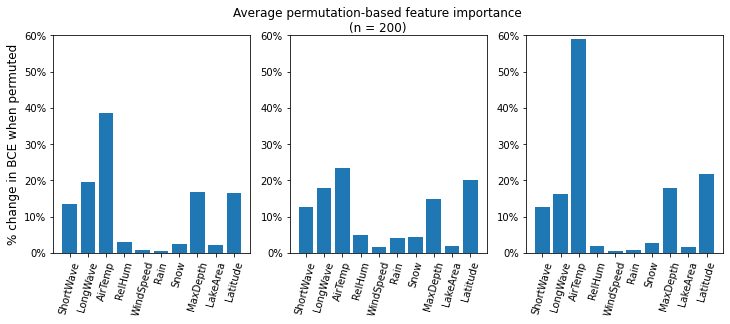

In [38]:
# original validation losses for scaling
avg_valid_loss = avg_valid_loss_list[avg_valid_loss_list != 0].min()
large_valid_loss = large_valid_loss_list[large_valid_loss_list != 0].min()
massive_valid_loss = massive_valid_loss_list[massive_valid_loss_list != 0].min()


fig, ax = plt.subplots(1, 3, figsize = (12, 4))

fig.suptitle('Average permutation-based feature importance\n(n = ' + str(perm_samples) + ')')

# plot changes in BCE
ax[0].bar(valid_variables, 100*(np.mean(avg_permutation_results, 0) - avg_valid_loss) / avg_valid_loss)
ax[1].bar(valid_variables, 100*(np.mean(large_permutation_results, 0) - large_valid_loss) / large_valid_loss)
ax[2].bar(valid_variables, 100*(np.mean(massive_permutation_results, 0) - massive_valid_loss) / massive_valid_loss)
# fix labels

for i in range(3):
    ax[i].set_ylim(0, 60)
    ax[i].set_xticks(range(len(valid_variables)), valid_variables, rotation=75)
    ax[i].set_yticks(ax[i].get_yticks(), [str(int(tick))+'%' for tick in ax[i].get_yticks()])
ax[0].set_ylabel('% change in BCE when permuted', fontsize = 12)


print('\nAvg model increasing importance:\t', valid_variables[np.argsort(np.mean(avg_permutation_results, 0))], '\n\n',
      '\nLarge model increasing importance:\t', valid_variables[np.argsort(np.mean(large_permutation_results, 0))], '\n\n',
      '\nMassive model increasing importance:\t', valid_variables[np.argsort(np.mean(massive_permutation_results, 0))])

In [39]:
100*(np.mean(avg_permutation_results, 0) - avg_valid_loss) / avg_valid_loss, np.sum(100*(np.mean(avg_permutation_results, 0) - avg_valid_loss) / avg_valid_loss)

(array([13.35169   , 19.52502141, 38.51361663,  2.86686807,  0.82611651,
         0.5211804 ,  2.39116718, 16.8817995 ,  2.09199705, 16.46200043]),
 113.43145718002471)

In [40]:
100*(np.mean(large_permutation_results, 0) - large_valid_loss) / large_valid_loss, np.sum(100*(np.mean(large_permutation_results, 0) - large_valid_loss) / large_valid_loss)

(array([12.74449503, 17.77238096, 23.3429104 ,  5.00451058,  1.65159737,
         4.18277436,  4.48355791, 14.88611212,  1.9701618 , 20.18866053]),
 106.22716105679467)

In [41]:
100*(np.mean(massive_permutation_results, 0) - massive_valid_loss) / massive_valid_loss, np.sum(100*(np.mean(massive_permutation_results, 0) - massive_valid_loss) / massive_valid_loss)

(array([12.66216422, 16.15296317, 58.89731853,  1.85596431,  0.35536774,
         0.73299513,  2.77232483, 17.88964451,  1.4807776 , 21.8123083 ]),
 134.6118283263366)

#### When using latitude, not using process-based inputs,  and comparing models of different sizes

Permutation-based mostly agree with EG results for the top dynamic variables. EG results focus on raw prediction, while permutation focuses on change in performance. 

Permutation results much more greatly emphasize max depth and latitude at the expense of incoming radiation.

The importance of air temperature in the massive model is very prominent.

<br><br><br><br><br>

# View PDP (average of ICE)

Rather than just importance and timing, let's also get an idea for how prediction vary over the range of input variables. This will be performed across many quantiles, including the training min and max, and values beyond the training min and max.

In [42]:
random_indices = np.random.choice(massive_valid_set_ICE_preds[0].reshape(resolution + 3, -1).shape[1], 1000)

C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/1455456820.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i, j].set_yticklabels(new_yticks)
C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/1455456820.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i, j].set_yticklabels(new_yticks)
C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/1455456820.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i, j].set_yticklabels(new_yticks)
C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/1455456820.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i, j].set_yticklabels(new_yticks)
C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/1455456820.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i, j].set_yticklabels(new_yticks)
C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/1455456820.py:54: UserWarning: Fix

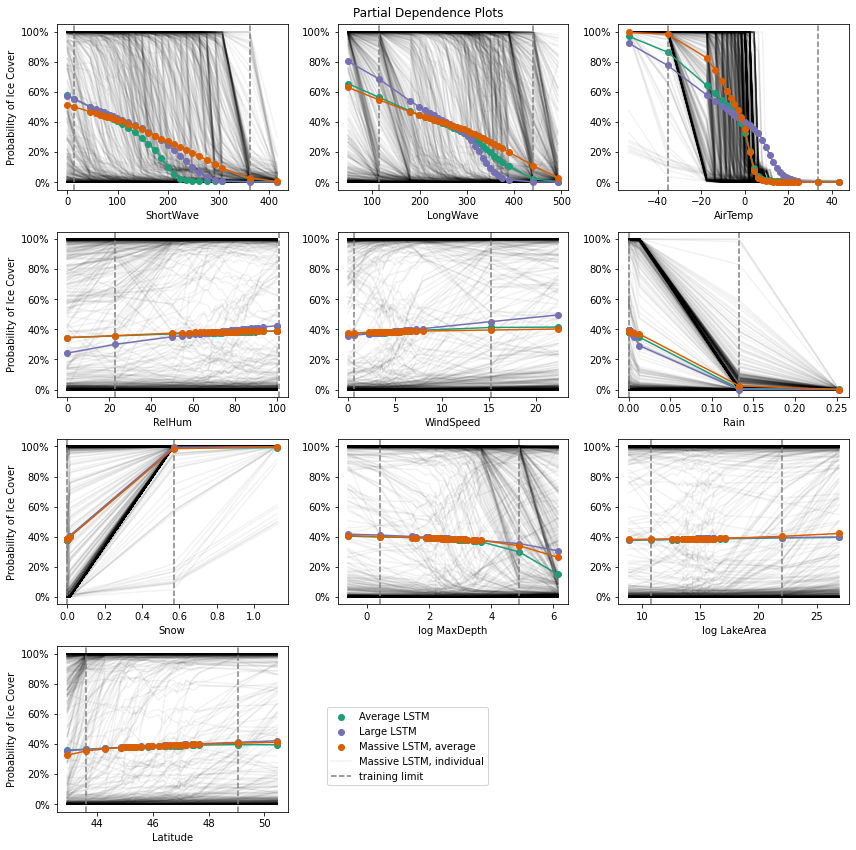

In [43]:
fig, ax = plt.subplots(4, 3, figsize = (12, 12))

for count, var_index in enumerate(range(len(valid_variables))):
    
    var_min = avg_min_max_scalars[var_index, 0].item()
    var_max = avg_min_max_scalars[var_index, 1].item()
    var_name = valid_variables[var_index]
    if var_name in ['MaxDepth', 'LakeArea']:
        var_name = 'log ' + var_name
    
    unscale_factor = var_max - var_min
    
    i = int(np.floor(count / 3))
    j = count % 3
    
    ax[i, j].plot(avg_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
             # reshape lumps all lakes and times together by variable
             np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                  color = '#1b9e77', zorder = 1)
    ax[i, j].scatter(avg_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'Average LSTM',
                  color = '#1b9e77', zorder = 1)
    ax[i, j].plot(large_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(large_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                  color = '#7570b3', zorder = 2)
    ax[i, j].scatter(large_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(large_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'Large LSTM',
                  color = '#7570b3', zorder = 2)
    ax[i, j].plot(massive_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                  color = '#d95f02', zorder = 3)
    ax[i, j].scatter(massive_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'Massive LSTM, average',
                  color = '#d95f02', zorder = 3)

    ax[i, j].plot(massive_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                  massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1)[:, random_indices],
                  alpha = 0.05, color = 'black', zorder = 0, label = 'Massive LSTM, individual')

    
    if j == 0:
        ax[i, j].set_ylabel('Probability of Ice Cover')
    ax[i, j].set_xlabel(var_name)
    ax[i, j].axvline(var_min, color = 'grey', linestyle = '--', label = 'training limit')
    ax[i, j].axvline(var_max, color = 'grey', linestyle = '--')
    #ax[i, j].set_ylim(0, 1)
    
    new_yticks = []
    for val in ax[i, j].get_yticks():
        new_yticks.append(str(int(100*val)) + '%')
    ax[i, j].set_yticklabels(new_yticks)
        
        
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), bbox_to_anchor = [0.575, 0.175])
    
#handles, labels = ax[i, j].get_legend_handles_labels()
#fig.legend(handles, labels, bbox_to_anchor = [0.575, 0.175])
ax[3, 1].axis('off')
ax[3, 2].axis('off')
plt.suptitle('Partial Dependence Plots')
plt.tight_layout()
#plt.savefig("../../PDPs_model_size_comparison.png", dpi = 300)

C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/4066009742.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i, j].set_yticklabels(new_yticks)
C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/4066009742.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i, j].set_yticklabels(new_yticks)
C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/4066009742.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i, j].set_yticklabels(new_yticks)
C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/4066009742.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i, j].set_yticklabels(new_yticks)
C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/4066009742.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i, j].set_yticklabels(new_yticks)
C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/4066009742.py:48: UserWarning: Fix

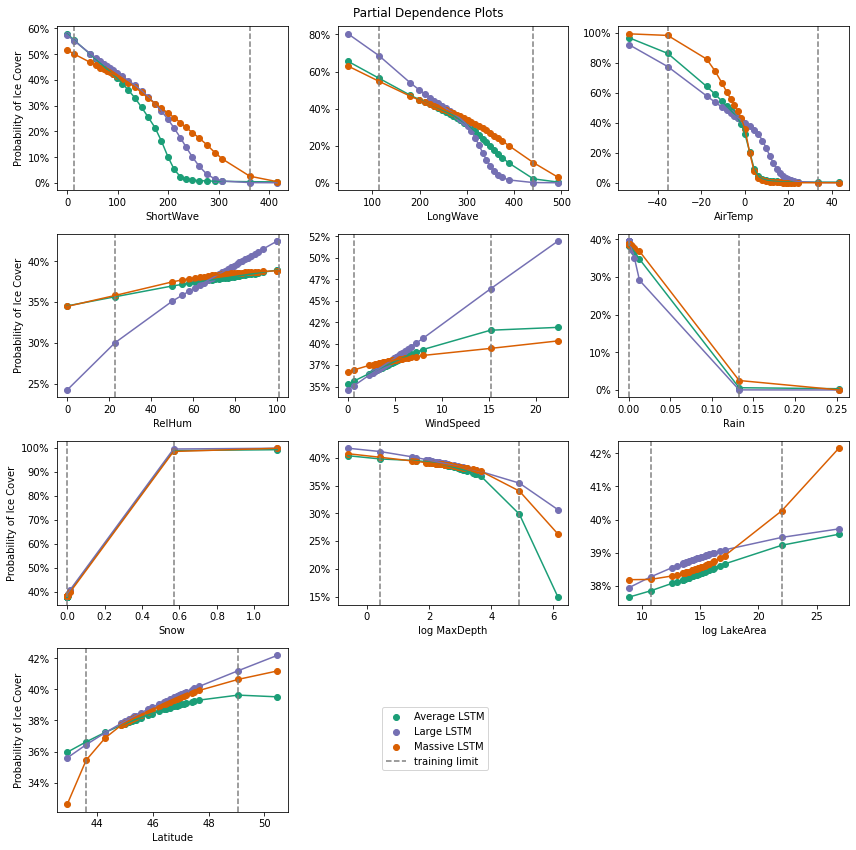

In [44]:
fig, ax = plt.subplots(4, 3, figsize = (12, 12))

for count, var_index in enumerate(range(len(valid_variables))):
    
    var_min = avg_min_max_scalars[var_index, 0].item()
    var_max = avg_min_max_scalars[var_index, 1].item()
    var_name = valid_variables[var_index]
    if var_name in ['MaxDepth', 'LakeArea']:
        var_name = 'log ' + var_name
    
    unscale_factor = var_max - var_min
    
    i = int(np.floor(count / 3))
    j = count % 3
    
    ax[i, j].plot(avg_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
             # reshape lumps all lakes and times together by variable
             np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                  color = '#1b9e77')
    ax[i, j].scatter(avg_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'Average LSTM',
                  color = '#1b9e77')
    ax[i, j].plot(large_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(large_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                  color = '#7570b3')
    ax[i, j].scatter(large_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(large_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'Large LSTM',
                  color = '#7570b3')
    ax[i, j].plot(massive_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                  color = '#d95f02')
    ax[i, j].scatter(massive_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'Massive LSTM',
                  color = '#d95f02')
    if j == 0:
        ax[i, j].set_ylabel('Probability of Ice Cover')
    ax[i, j].set_xlabel(var_name)
    ax[i, j].axvline(var_min, color = 'grey', linestyle = '--', label = 'training limit')
    ax[i, j].axvline(var_max, color = 'grey', linestyle = '--')
    #ax[i, j].set_ylim(0, 1)
    
    new_yticks = []
    for val in ax[i, j].get_yticks():
        new_yticks.append(str(int(100*val)) + '%')
    ax[i, j].set_yticklabels(new_yticks)
        
    
handles, labels = ax[i, j].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor = [0.575, 0.175])
ax[3, 1].axis('off')
ax[3, 2].axis('off')
plt.suptitle('Partial Dependence Plots')
plt.tight_layout()
#plt.savefig("../../PDPs_model_size_comparison.png", dpi = 300)

C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/3767233610.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i, j].set_yticklabels(new_yticks)
C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/3767233610.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i, j].set_yticklabels(new_yticks)
C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/3767233610.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i, j].set_yticklabels(new_yticks)
C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/3767233610.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i, j].set_yticklabels(new_yticks)
C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/3767233610.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i, j].set_yticklabels(new_yticks)
C:\Users\jdiaz\AppData\Local\Temp\1/ipykernel_5828/3767233610.py:48: UserWarning: Fix

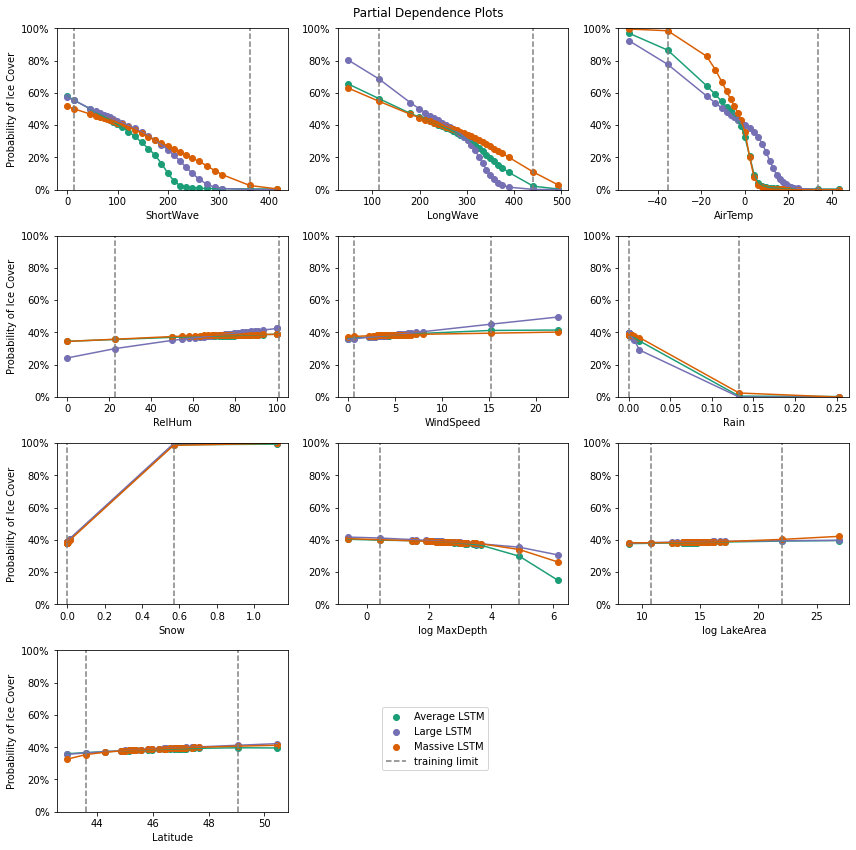

In [45]:
fig, ax = plt.subplots(4, 3, figsize = (12, 12))

for count, var_index in enumerate(range(len(valid_variables))):
    
    var_min = avg_min_max_scalars[var_index, 0].item()
    var_max = avg_min_max_scalars[var_index, 1].item()
    var_name = valid_variables[var_index]
    if var_name in ['MaxDepth', 'LakeArea']:
        var_name = 'log ' + var_name
    
    unscale_factor = var_max - var_min
    
    i = int(np.floor(count / 3))
    j = count % 3
    
    ax[i, j].plot(avg_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
             # reshape lumps all lakes and times together by variable
             np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                  color = '#1b9e77')
    ax[i, j].scatter(avg_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'Average LSTM',
                  color = '#1b9e77')
    ax[i, j].plot(large_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(large_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                  color = '#7570b3')
    ax[i, j].scatter(large_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(large_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'Large LSTM',
                  color = '#7570b3')
    ax[i, j].plot(massive_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                  color = '#d95f02')
    ax[i, j].scatter(massive_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'Massive LSTM',
                  color = '#d95f02')
    if j == 0:
        ax[i, j].set_ylabel('Probability of Ice Cover')
    ax[i, j].set_xlabel(var_name)
    ax[i, j].axvline(var_min, color = 'grey', linestyle = '--', label = 'training limit')
    ax[i, j].axvline(var_max, color = 'grey', linestyle = '--')
    ax[i, j].set_ylim(0, 1)
    
    new_yticks = []
    for val in ax[i, j].get_yticks():
        new_yticks.append(str(int(100*val)) + '%')
    ax[i, j].set_yticklabels(new_yticks)
        
    
handles, labels = ax[i, j].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor = [0.575, 0.175])
ax[3, 1].axis('off')
ax[3, 2].axis('off')
plt.suptitle('Partial Dependence Plots')
plt.tight_layout()
plt.savefig("../../PDPs_model_size_comparison.png", dpi = 300)

In [46]:
for var_index in range(len(valid_variables)):
    
    avg_min_extreme_pred = np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1)[0]
    avg_max_extreme_pred = np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1)[-1]
    
    large_min_extreme_pred = np.mean(large_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1)[0]
    large_max_extreme_pred = np.mean(large_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1)[-1]
    
    massive_min_extreme_pred = np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1)[0]
    massive_max_extreme_pred = np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1)[-1]
    
    ordered_names = ['avg', 'large', 'massive']
    min_extreme_preds = [avg_min_extreme_pred,
                         large_min_extreme_pred,
                         massive_min_extreme_pred]
    median_min_extreme_pred = np.median(min_extreme_preds)
    
    max_extreme_preds = [avg_max_extreme_pred,
                         large_max_extreme_pred,
                         massive_max_extreme_pred]
    median_max_extreme_pred = np.median(max_extreme_preds)
    
    relative_min_extremity = np.abs(min_extreme_preds - median_min_extreme_pred)
    relative_max_extremity = np.abs(max_extreme_preds - median_max_extreme_pred)
    
    print(valid_variables[var_index])
    print('Minimum end')
    if np.max(np.abs(relative_min_extremity)) > 0.05:
        emphasizer = '**********************'
    else:
        emphasizer = ''
    print(median_min_extreme_pred,
          ordered_names[np.argmax(relative_min_extremity)],
          min_extreme_preds[np.argmax(relative_min_extremity)],
          min_extreme_preds[np.argmax(relative_min_extremity)] - median_min_extreme_pred,
          emphasizer)
    print('Maximum end')
    if np.max(np.abs(relative_max_extremity)) > 0.05:
        emphasizer = '**********************'
    else:
        emphasizer = ''
    print(median_max_extreme_pred,
          ordered_names[np.argmax(relative_max_extremity)],
          max_extreme_preds[np.argmax(relative_max_extremity)],
          max_extreme_preds[np.argmax(relative_max_extremity)] - median_max_extreme_pred,
          emphasizer)
    print('\n')

ShortWave
Minimum end
0.574621886647364 massive 0.5161315170055493 -0.058490369641814755 **********************
Maximum end
0.004313869023353423 large 0.0008896157550694568 -0.003424253268283966 


LongWave
Minimum end
0.6552072967971369 large 0.8034331260081298 0.14822582921099292 **********************
Maximum end
0.004617822779202955 massive 0.030652978756551135 0.02603515597734818 


AirTemp
Minimum end
0.9693249982218348 large 0.923117905269986 -0.04620709295184877 
Maximum end
0.0009325722374006192 avg 0.003858393500778142 0.002925821263377523 


RelHum
Minimum end
0.3447670923693061 large 0.24227011998598458 -0.1024969723833215 **********************
Maximum end
0.38937398993411504 large 0.424980597037363 0.03560660710324798 


WindSpeed
Minimum end
0.36205417953015967 massive 0.3735753217500498 0.011521142219890146 
Maximum end
0.41517573227243315 large 0.4956697121653243 0.08049397989289114 **********************


Rain
Minimum end
0.3870756297003368 large 0.39563707991404645 

PDP take-aways:

#### When using latitude, not using process-based inputs, and comparing models of different sizes

See numbers above and paper.

<br><br><br><br><br>

# Conclusions

#### When using latitude, not using process-based models, and comparing models of different sizes

See paper